### Example 1: The DC motor model

直流电机模型:

$$
\begin{cases}
	V_m\left( t \right) =K_b\omega _m\left( t \right) ,&		\\
	V_U\left( t \right) =L\frac{di\left( t \right)}{dt}+Ri\left( t \right) +V_m\left( t \right) ,&		\\
	T\left( t \right) =K_mi\left( t \right) ,&		\\
	J_m\frac{d\omega _m\left( t \right)}{dt}=-K_f\omega _m\left( t \right) +T\left( t \right) ,&		\\
\end{cases}
$$


**1. 状态变量 (State Variables, $x(t)$)**

状态变量是描述系统动态行为的最小一组变量。知道了当前时刻的状态变量和未来的输入，我们就能预测系统未来的所有行为。

- **$\omega_m(t)$ (角速度)** 和 **$i(t)$ (电流)**:

  - **控制目标：** 论文的目标就是设计一个控制器来操纵这两个状态变量，使它们在受到扰动时能回归到稳定点（例如，都变为 0）。

**2. 控制输入 (Control Input, $u(t)$)**

控制输入是我们（控制器）可以主动施加给系统，用以改变其状态的外部信号。

- **$V_U(t)$ (外部电压)**
  - **角色：** 它是我们唯一可以操纵的“杠杆”。通过改变施加在电机两端的电压，我们可以间接地影响电路中的电流 $i(t)$ 和电机的角速度 $\omega_m(t)$。论文的核心就是设计一个智能的策略来决定这个 $V_U(t)$ 应该如何根据系统状态来变化。

**3. 系统输出 (System Output, $y(t)$)**

系统输出是我们能够从系统中**测量**到的变量。控制器通常是根据这些测量值来做出决策的。

- **$y(t)$**: 论文中虽然没有为这个具体的例子指定输出矩阵 $D_i$，但通常输出可以是状态变量本身或它们的线性组合。例如，我们可能只能测量电机的**角速度** $\omega_m(t)$，那么输出就是 $y(t) = \omega_m(t)$；或者我们能同时测量角速度和电流，那么输出就是 $y(t) = x(t)$。

**4. 系统参数**

这些是定义系统固有物理特性的常数。

- **$L, R, K_b, K_m, J_m, K_f$**: 这些都是**系统参数**。
  - **角色：** 它们决定了系统内部状态变量之间以及输入与状态之间的关系。在状态空间方程 $\dot{x} = Ax + Bu$ 中，这些参数的值构成了矩阵 $A$ 和 $B$ 的元素。
  - **与论文的关联：** 这篇论文研究的是**切换系统**，其核心特点就是这些参数**不是固定不变的**。例如，电机的电阻 $R$ 可能会因为温度变化而改变。论文将这些不同的参数组合定义为不同的**模式 (Mode)**，用下标 $i$ 表示（$A_i, B_i$），并且这些模式之间的切换是随机的，这就构成了论文所研究的“半马尔可夫切换系统”的挑战所在。

**总结一下，从控制理论的角度看，整个问题可以描述为：**

> 如何设计一个控制律，通过操纵**输入** $V_U(t)$，来使得系统的**状态**（$\omega_m(t)$ 和 $i(t)$）趋于稳定，即使在描述系统动态的**参数**（$A_i, B_i$）随机切换的情况下。


**状态空间方程**

$$
\dot{x}\left( t \right) =\left( A_i+\Delta A_i \right) x\left( t \right) +B_iu\left( t \right) +C_i\omega \left( t \right)
$$


- $\dot{x}\left( t \right)$：状态向量
- $A_i$：系统矩阵
- $\Delta A_i$：参数不确定性矩阵
- $B_iu\left( t \right)$：控制输入
- $C_i\omega \left( t \right)$：外部扰动项


#### 第一步：环境设置与系统参数定义


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- 1. 定义论文中的系统参数 (Example 1: DC Motor) ---

# 根据论文表1 (Table 1) [cite: 753] 和相关描述 [cite: 741, 742] 定义三个模式下的系统矩阵 A 和 B
# Mode 1 (i=1)
A1 = np.array([[-0.479908, 5.1546], [-3.81625, 14.4723]])
B1 = np.array([[5.8705212, 0], [0, 15.50107]])

# Mode 2 (i=2)
A2 = np.array([[-1.60261, 9.1632], [-0.5918697, 3.0317]])
B2 = np.array([[10.285129, 0], [0, 2.2282663]])

# Mode 3 (i=3)
A3 = np.array([[0.634617, 0.917836], [-0.50569, 2.48116]])
B3 = np.array([[0.7874647, 0], [0, 1.5302844]])

# 将矩阵放入列表中，方便索引
A_list = [A1, A2, A3]
B_list = [B1, B2, B3]

# 定义外部扰动矩阵 C [cite: 773]
C1 = np.array([[0.1, 0], [0.1, 0.1]])
C2 = np.array([[0.12, 0.1], [0, 0.1]])
C3 = np.array([[0.1, 0], [0, 0.14]])
C_list = [C1, C2, C3]

# --- 2. 定义控制器和事件触发器参数 (Case 1: H_infinity performance) ---
# 这些是论文通过求解LMI得到的现成结果 [cite: 780]

# 控制器增益矩阵 K
K1 = np.array([[-0.7523, -0.3702], [0.2026, -1.5200]])
K2 = np.array([[-0.3678, -0.3307], [0.4398, -6.5651]])
K3 = np.array([[-5.8111, -1.7759], [0.7931, -9.4983]])
K_list = [K1, K2, K3]

# 事件触发矩阵 Lambda (Λ)
Lambda1 = np.array([[3.3904, -6.1099], [-6.1099, 42.1919]])
Lambda2 = np.array([[2.4372, -1.6619], [-1.6619, 22.7854]])
Lambda3 = np.array([[2.7637, -2.1649], [-2.1649, 22.4972]])
Lambda_list = [Lambda1, Lambda2, Lambda3]

# --- 3. 定义仿真相关的其他参数 ---
# 根据论文例1的设置
delta = 0.1
d = 0.05
sigma = 0.01

# 初始条件和仿真时间
x0 = np.array([0.14, 0.05])  # 为了更好地观察收敛过程，我们设置一个非零初始值
t_span = [0, 15]
t_eval = np.linspace(t_span[0], t_span[1], 3000)  # 评估时间的点

print("第一步完成：所有系统和控制器参数已定义完毕。")
print(f"系统状态维度: {x0.shape[0]}")
print(f"模式数量: {len(A_list)}")


第一步完成：所有系统和控制器参数已定义完毕。
系统状态维度: 2
模式数量: 3


#### 第二步：仿真半马尔可夫切换信号

转移概率矩阵 P_ij:
[[0.  0.5 0.5]
 [0.2 0.  0.8]
 [0.8 0.2 0. ]]


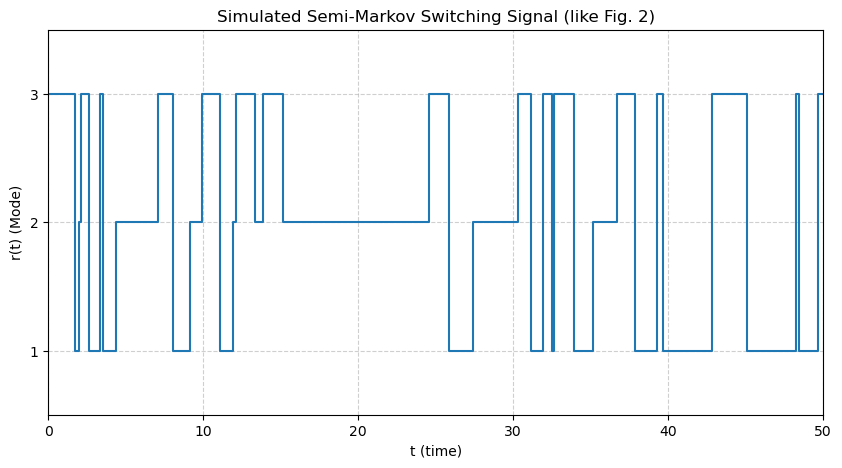

In [3]:
# --- 4. 仿真半马尔可夫切换信号 ---

# 转移强度矩阵 q_ij (来自论文)
q_ij = np.array([[0, 0.5, 0.5], [0.2, 0, 0.8], [0.8, 0.2, 0]])

# 将强度矩阵转换为概率矩阵
# 方法：将每一行除以该行的总和
transition_prob = q_ij / q_ij.sum(axis=1, keepdims=True)

print("转移概率矩阵 P_ij:")
print(transition_prob)


def simulate_switching_signal(total_time):
    """
    模拟半马尔可夫切换信号
    :param total_time: 总仿真时长
    :return: (time_points, modes) 切换时间点列表和对应的模式列表
    """
    # 初始状态
    current_time = 0.0
    # 模式用1, 2, 3表示。Python内部索引为0, 1, 2。我们从模式3开始，以匹配图2的初始状态。
    current_mode_idx = 2  # 对应模式3

    time_points = [current_time]
    modes = [current_mode_idx + 1]

    while current_time < total_time:
        # 1. 根据当前模式确定停留时间 (Sojourn Time)
        sojourn_time = 0
        if current_mode_idx == 0:  # 模式1
            # 威布尔分布，形状参数 beta_2 = 2
            sojourn_time = np.random.weibull(a=2)
        elif current_mode_idx == 1:  # 模式2
            # 威布尔分布，形状参数 beta_2 = 3
            sojourn_time = np.random.weibull(a=3)
        elif current_mode_idx == 2:  # 模式3
            # 指数分布，参数 lambda = 0.5。Numpy需要的是 scale = 1/lambda
            sojourn_time = np.random.exponential(scale=1.0 / 0.5)

        # 更新时间
        current_time += sojourn_time

        # 2. 根据转移概率矩阵确定下一个模式
        # 定义可能的下一个模式（除去当前模式）
        possible_next_modes = [0, 1, 2]
        # 获取当前模式的转移概率
        probabilities = transition_prob[current_mode_idx]

        # 使用np.random.choice选择下一个模式
        next_mode_idx = np.random.choice(possible_next_modes, p=probabilities)

        # 记录切换点
        time_points.append(current_time)
        modes.append(current_mode_idx + 1)  # 记录切换前的模式，用于绘图

        # 更新模式
        current_mode_idx = next_mode_idx

    return np.array(time_points), np.array(modes)


# 运行仿真，生成切换信号 (为了复现图2，我们将时间设置为50)
sim_time_fig2 = 50
time_points, modes = simulate_switching_signal(sim_time_fig2)

# --- 5. 可视化切换信号 ---
plt.figure(figsize=(10, 5))
plt.step(time_points, modes, where="post")
plt.title("Simulated Semi-Markov Switching Signal (like Fig. 2)")
plt.xlabel("t (time)")
plt.ylabel("r(t) (Mode)")
plt.yticks([1, 2, 3])
plt.xlim(0, sim_time_fig2)
plt.ylim(0.5, 3.5)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

#### 第三步：实现MDSETM控制器与事件触发条件

In [5]:
# --- 6. 实现控制器和事件触发逻辑 ---


class SystemSimulator:
    def __init__(self, A, B, C, K, Lambda, switch_t, switch_m, d, sigma, delta):
        # 存储系统和控制器矩阵
        self.A_list = A
        self.B_list = B
        self.C_list = C
        self.K_list = K
        self.Lambda_list = Lambda

        # 存储切换信号
        self.switch_times = switch_t
        self.switch_modes = switch_m

        # 存储事件触发参数
        self.d = d
        self.sigma = sigma
        self.delta = delta

        # 初始化仿真状态变量
        self.last_trigger_time = -1  # 上次触发时间，初始化为-1
        self.x_triggered = None  # 上次触发时的状态

        # 用于记录结果
        self.trigger_times_history = []
        self.control_input_history = []
        self.mode_history = []

    def get_mode_idx(self, t):
        """根据时间t，从切换信号中获取当前模式的索引 (0, 1, or 2)"""
        # searchsorted找到t应该插入的位置，返回的索引是右边界
        # 我们需要这个位置前一个区间的模式
        # 例如 t=3, switch_times=[0, 2, 5], 返回索引2, 我们需要modes[1]
        idx = np.searchsorted(self.switch_times, t, side="right")
        return self.switch_modes[idx - 1] - 1

    def disturbance(self, t):
        """定义外部扰动 w(t)"""
        return np.array([np.exp(-t), np.exp(-t)])

    def dynamics(self, t, x):
        """
        定义整个闭环系统的动态，用于ODE求解器
        :param t: 当前时间
        :param x: 当前状态向量 x(t)
        """
        # 1. 获取当前模式
        current_mode_idx = self.get_mode_idx(t)
        self.mode_history.append(current_mode_idx + 1)

        # 2. 检查事件触发条件 (Equation 4)
        trigger_event = False
        # 首次运行时必须触发
        if self.last_trigger_time == -1:
            trigger_event = True
        # 检查是否超过最小触发间隔 d
        elif t >= self.last_trigger_time + self.d:
            # 计算误差 e(t) = x(t) - x(t_s)
            error = x - self.x_triggered

            # 获取当前模式的 Lambda 矩阵
            Lambda_i = self.Lambda_list[current_mode_idx]

            # 计算触发条件左侧 (LHS)
            lhs = error.T @ Lambda_i @ error

            # 计算当前扰动 w(t)
            w_t = self.disturbance(t)

            # 计算触发条件右侧 (RHS)
            rhs = self.sigma * (x.T @ Lambda_i @ x) + self.delta * (w_t.T @ w_t)

            if lhs >= rhs:
                trigger_event = True

        # 如果触发事件发生
        if trigger_event:
            self.last_trigger_time = t
            self.x_triggered = x
            self.trigger_times_history.append(t)

        # 3. 计算控制输入 u(t) (Equation 3)
        # 控制输入 u(t) 始终基于上一次触发的状态 x(t_s)
        K_i = self.K_list[current_mode_idx]
        u = K_i @ self.x_triggered
        self.control_input_history.append(u)  # 记录控制输入

        # 4. 计算系统状态的导数 dx/dt (Equation 1)
        A_i = self.A_list[current_mode_idx]
        B_i = self.B_list[current_mode_idx]
        C_i = self.C_list[current_mode_idx]
        w_t = self.disturbance(t)

        dxdt = A_i @ x + B_i @ u + C_i @ w_t

        return dxdt


print("第三步完成：系统模拟器类 SystemSimulator 已定义。")
print("这个类封装了系统的切换、事件触发和控制逻辑。")


第三步完成：系统模拟器类 SystemSimulator 已定义。
这个类封装了系统的切换、事件触发和控制逻辑。


#### 第四步：搭建并运行闭环系统仿真

In [6]:
# --- 7. 运行完整的闭环仿真 ---

# 1. 为本次仿真生成一个切换信号实例 (0-15秒)
# 我们需要一个固定的随机种子来确保每次运行这部分代码时，切换信号都一样，便于分析
np.random.seed(42)
simulation_time_points, simulation_modes = simulate_switching_signal(t_span[1])

# 2. 实例化系统模拟器
# 将之前定义的所有参数和刚刚生成的切换信号传入
simulator = SystemSimulator(
    A=A_list,
    B=B_list,
    C=C_list,
    K=K_list,
    Lambda=Lambda_list,
    switch_t=simulation_time_points,
    switch_m=simulation_modes,
    d=d,
    sigma=sigma,
    delta=delta,
)

print("开始运行系统仿真... (这可能需要几秒钟)")
# 3. 调用ODE求解器
# simulator.dynamics 是我们传入的核心函数
# max_step 限制了求解器的最大步长，这对于精确捕捉事件触发点很重要
sol = solve_ivp(
    fun=simulator.dynamics,
    t_span=t_span,
    y0=x0,
    t_eval=t_eval,
    method="RK45",
    max_step=0.01,  # 限制最大步长
)

print("仿真完成！")
print(f"总仿真时间: {sol.t[-1]:.2f} 秒")
print(f"总事件触发次数: {len(simulator.trigger_times_history)}")

# 提取结果用于绘图
# sol.y 的形状是 (状态维度, 时间点数量)，我们需要转置
state_trajectory = sol.y.T
time_vector = sol.t


开始运行系统仿真... (这可能需要几秒钟)
仿真完成！
总仿真时间: 15.00 秒
总事件触发次数: 130


#### 第五步：结果可视化与分析

##### 5.1 状态轨迹与控制输入

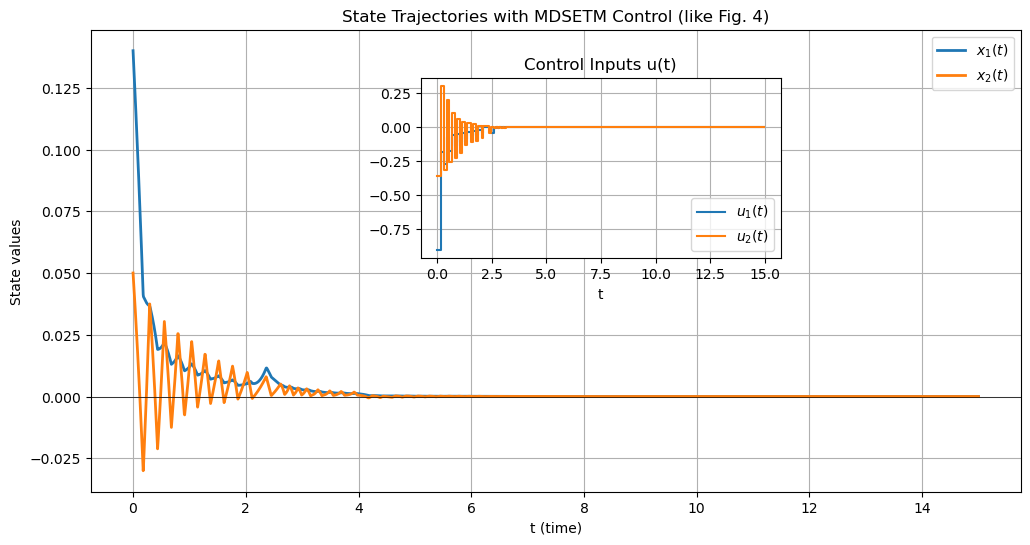

In [7]:
# --- 8. 可视化状态轨迹和控制输入 ---

# 准备控制输入u(t)的绘图数据
# u(t)是分段常数，只在触发时刻更新
trigger_times = simulator.trigger_times_history
# 我们需要重新计算在每个触发点的控制输入值
u_values_at_triggers = []
for t_trig in trigger_times:
    # 找到t_trig在仿真时间向量中的索引
    idx = np.searchsorted(time_vector, t_trig)
    # 获取该时刻的状态x(t_s)和模式
    x_s = state_trajectory[idx]
    mode_idx_s = simulator.get_mode_idx(t_trig)
    # 计算控制输入
    u_s = K_list[mode_idx_s] @ x_s
    u_values_at_triggers.append(u_s)

u_values_at_triggers = np.array(u_values_at_triggers)

# 创建主图
fig, ax = plt.subplots(figsize=(12, 6))

# 绘制状态轨迹
ax.plot(time_vector, state_trajectory[:, 0], label="$x_1(t)$", lw=2)
ax.plot(time_vector, state_trajectory[:, 1], label="$x_2(t)$", lw=2)
ax.set_title("State Trajectories with MDSETM Control (like Fig. 4)")
ax.set_xlabel("t (time)")
ax.set_ylabel("State values")
ax.legend()
ax.grid(True)
ax.axhline(0, color="black", lw=0.5)  # 添加 y=0 参考线

# 创建插图
ax_inset = fig.add_axes([0.4, 0.5, 0.3, 0.3])  # [left, bottom, width, height]
ax_inset.step(trigger_times, u_values_at_triggers[:, 0], where="post", label="$u_1(t)$")
ax_inset.step(trigger_times, u_values_at_triggers[:, 1], where="post", label="$u_2(t)$")
ax_inset.set_xlabel("t")
ax_inset.set_title("Control Inputs u(t)")
ax_inset.legend()
ax_inset.grid(True)

plt.show()


##### 5.2 事件触发间隔

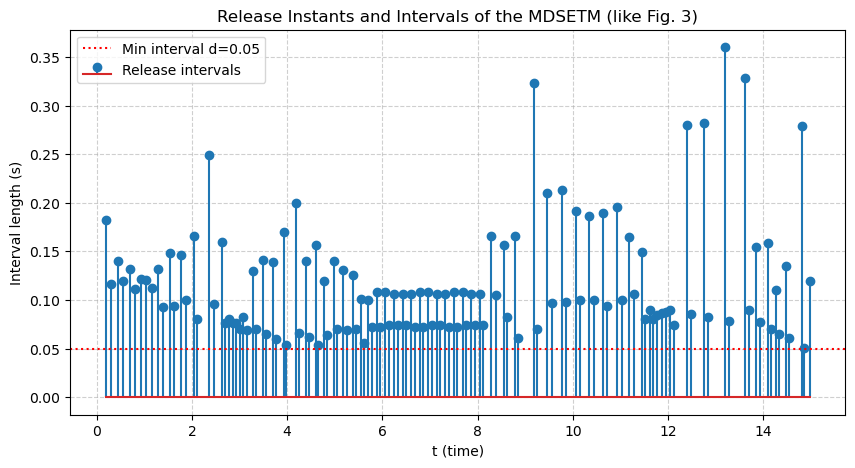

In [8]:
# --- 9. 可视化事件触发间隔 ---

# 计算触发间隔
release_intervals = np.diff(simulator.trigger_times_history)
# 触发时刻（从第二个点开始，因为它代表第一个间隔的结束）
release_instants = simulator.trigger_times_history[1:]

plt.figure(figsize=(10, 5))

# 使用stem图来复现论文中的样式
plt.stem(release_instants, release_intervals, label="Release intervals")
plt.title("Release Instants and Intervals of the MDSETM (like Fig. 3)")
plt.xlabel("t (time)")
plt.ylabel("Interval length (s)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
# 绘制最小触发间隔d的参考线
plt.axhline(d, color="red", linestyle=":", lw=1.5, label=f"Min interval d={d}")
plt.legend()

plt.show()
